# Description

This notebook creates the figure we use to compare how our results relate to prior CPM work

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
our_acc = pd.read_csv('../resources/cpm/final_avg_accuracies.csv', index_col=0)
our_acc.index.name='Target'
our_acc.columns.name='Accuracy'
our_acc.loc[['Thought Pattern 1','Thought Pattern 2','Wakefulness','Images','Surroundings','Past']]

Accuracy,Pearson R,Spearman R
Target,,
Thought Pattern 1,0.148283,0.125089
Thought Pattern 2,0.208355,0.220099
Wakefulness,0.281511,0.290120
Images,0.139341,0.108633
Surroundings,0.171443,0.164560
Past,0.130975,0.116012


### 1. Load the data

In [4]:
data=pd.read_excel('../resources/cpm_literature_search/CPM_Literature_Search.xlsx', na_filter=True, skiprows=2, sheet_name='FINAL')
data.columns=['Title','Year','# Subjects','Target','Category','Atlas','# ROIs','Pos Nw | R', 'Pos Nw | Rho', 'Neg Nw | R', 'Neg Nw | Rho','Both Nw | R','Both Nw | Rho','Cross Validation','Exclusion','Extra1']
data.drop(['Extra1'],axis=1, inplace=True)

In [5]:
scopus_num_studies = data['Title'].ffill().unique().shape[0]
print ("++ INFO: Number of papers found in scopus: %d" % scopus_num_studies)

++ INFO: Number of papers found in scopus: 88


### 2. Count number of excluded studies per reason

Report the number of studies excluded from further analysis and the reason for exclusion

In [6]:
data['Exclusion'].value_counts()

Exclusion
Not Whole Brain / ROI Level        10
Substantially modified CPM          8
CPM on task data                    6
Review Article                      3
Incompatible Accuracy Reporting     2
Non Human data                      1
EEG Study                           1
Name: count, dtype: int64

In [7]:
print('++ INFO: Number of studies passing initial exclusion criteria: %d' % (scopus_num_studies - data['Exclusion'].value_counts().sum()))

++ INFO: Number of studies passing initial exclusion criteria: 57


### 3. Remove excluded studies

In [8]:
# Remove excluded studies
data = data[data['Exclusion'].isnull()]
data = data.drop(['Exclusion'],axis=1)
data = data.reset_index(drop=True)

In [9]:
data = data.ffill()

In [10]:
data.sample(10)

,Title,Year,# Subjects,Target,Category,Atlas,# ROIs,Pos Nw | R,Pos Nw | Rho,Neg Nw | R,Neg Nw | Rho,Both Nw | R,Both Nw | Rho,Cross Validation
17,Sex differences in functional connectivity and...,2024.0,71 - Males,Montreal Cognitive Assesment Scores,Clinical,AAL,90,0.23,N/R,(NS),N/R,N/R,N/R,LOOCV
104,Connectome-based modeling reveals a resting-st...,2023.0,560,rumination,Cognition,400 ROI Schaefer,400,0.045 (NS),N/R,0.152,N/R,N/R,N/R,LOOCV
21,Task and Resting-State Functional Connectivity...,2023.0,29,Driving Lapses,Personality/Well-being,Shen 268-node,178,0.4,N/R,-0.56 (NS),N/R,N/R,N/R,LOOCV
14,The individualized prediction of cognitive tes...,2020.0,91,Mini-mental State Examination,Cognition,AAL,90,0.51,N/R,0.52,N/R,0.54,N/R,LOOCV
81,Do intrinsic brain functional networks predict...,2020.0,87 - (preschoolers),working memory,Cognition,Shen 268-node,268,N/R,N/R,N/R,N/R,N/R,0.118 (NS),5-Fold CV
73,Trait repetitive negative thinking in depressi...,2023.0,62,Ruminative Response Scale,Clinical,Shen 268-node,230,N/R,N/R,N/R,N/R,N/R,0.613,5-Fold CV
77,Connectome-based model predicts individual psy...,2022.0,84,S-PTS (Psychopathic traits),Personality/Well-being,Dosenbach,142,N/R,0.129 (NS),N/R,0.309,N/R,0.353,LOOCV and k fold
20,Task and Resting-State Functional Connectivity...,2023.0,29,Impulsivity,Personality/Well-being,Shen 268-node,178,-0.27 (NS),N/R,-0.09 (NS),N/R,N/R,N/R,LOOCV
86,Connectome-Based Predictive Modeling of Indivi...,2021.0,76,Anxiety,Clinical,Shen 268-node,268,N/R,-0.01 (NS),N/R,0.33,N/R,N/R,LOOCV
59,The Functional Brain Organization of an Indivi...,2019.0,99,ADOS Social Affect score,Clinical,Shen 268-node,268,N/R,N/R,N/R,N/R,0.53,N/R,LOOCV


In [11]:
data['Year']       = data['Year'].astype(int)
data['# Subjects'] = [int(str(i).split('-')[0]) for i in data['# Subjects']]

data = data.replace('N/R',np.nan)

for col in ['Pos Nw | R','Pos Nw | Rho','Neg Nw | R','Neg Nw | Rho','Both Nw | R','Both Nw | Rho']:
    data[col] = [i if ('NS' not in str(i)) else np.nan for i in data[col]]

In [12]:
print('++ Number of reported models: %d' % data[['Pos Nw | R','Neg Nw | R','Both Nw | R','Pos Nw | Rho','Neg Nw | Rho','Both Nw | Rho']].melt().dropna().shape[0])

++ Number of reported models: 159


In [13]:
data['Category'].value_counts()

Category
Clinical                  53
Cognition                 32
Personality/Well-being    26
Name: count, dtype: int64

### Plot Pearson's R results

In [14]:
data2plot_R = None
for category in ['Personality/Well-being','Clinical','Cognition']:
    aux = data.set_index('Category').loc[category][['Pos Nw | R','Neg Nw | R','Both Nw | R']].melt().dropna()
    aux['Category'] = category
    aux.drop(['variable'],axis=1,inplace=True)
    aux.columns=['Pearson R','Category']
    if data2plot_R is None:
        data2plot_R = aux
    else:
        data2plot_R = pd.concat([data2plot_R,aux])
data2plot_R = data2plot_R.reset_index(drop=True)

In [15]:
data2plot_R['Category'].value_counts()

Category
Cognition                 43
Clinical                  36
Personality/Well-being    21
Name: count, dtype: int64

(-0.5, 2.5)

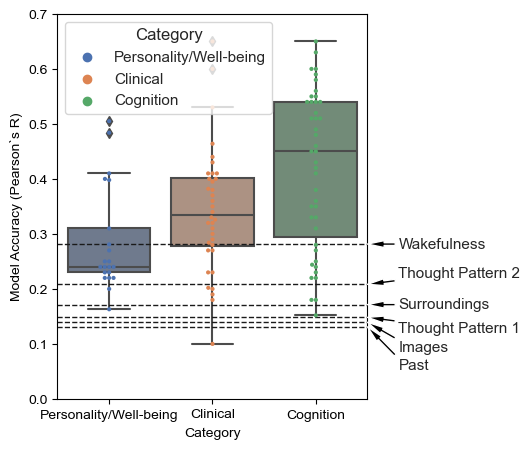

In [16]:
label_pos_extra = np.array([0,.02,0,-.02,-.045,-.07])
fig, ax = plt.subplots(1,1,figsize=(4,5))
sns.set(font_scale=1)
sns.set_style('white')
sns.boxplot(data=data2plot_R,x='Category',y='Pearson R',saturation=0.3)
sns.swarmplot(data=data2plot_R,x='Category',y='Pearson R', hue='Category',s=3)
for i, TARGET in enumerate(['Wakefulness','Thought Pattern 2','Surroundings','Thought Pattern 1','Images','Past']):
    ax.hlines(our_acc.loc[TARGET,'Pearson R'],-.5,2.5,'k', linestyles='dashed', label=TARGET, lw=1)
    ax.annotate(TARGET, xy=(2.5, our_acc.loc[TARGET,'Pearson R']), xytext=(2.8,our_acc.loc[TARGET,'Pearson R']+label_pos_extra[i]) ,
            arrowprops=dict(facecolor='black',width=2, headwidth=5), annotation_clip=False, fontsize=11, verticalalignment='center')
    #ax.text(2.6,our_acc.loc[TARGET,'Pearson R']*.96,TARGET,arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_ylabel('Model Accuracy (Pearson`s R)')
plt.ylim((0.0,.7))
plt.xlim((-.5,2.5))